# Replicating analysis presented in "GRAFIMO: variant and haplotype aware motif scanning on pangenome graphs"

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import collections
import time
import os
import sys

## Introduction

GRAFIMO is a command-line tool to search DNA motifs represented as Position Weighted Matrices (PWMs) in pangenome variantion graphs (VGs). Scanning VGs allows to search the motifs in thousands of genomes in a single run, considering the genetic variation present within the population of the considered individuals.

GRAFIMO provides an efficient method to study how genetic variation affects DNA motif structure and can help in prioritizing genomic regions, regulating gene expression, which would be missed considering only the reference genome sequence.

In this notebook will be reproduced the results presented in the manuscript "GRAFIMO: variant and haplotype aware motif scanning on pangenome graphs".

To showcase GRAFIMO utility we searched three Transcription Factor (TF) motifs on a hg38 genome assembly VG, enriched with genetic variants (SNPs and indels) of 2548 individuals from the 1000 Genome Project (1000GP) phase 3 (Zheng-Bradley *et al.*, 2017; Lowy-Gallego *et al.*, 2019). The considered variants from 1000GP were phased and belonged to 2548 individuals, from 26 different populations, for a total of 5096 haplotypes (forward and reverse strand).

We searched potential occurrences of three TFs with different length, evolutionary conservation and information content from JASPAR database (Fornes *et al.*, 2020):

- **CTCF** (JASPAR ID MA0139.1)

- **ATF3** (JASPAR ID MA0605.2)

- **GATA1** (JASPAR ID MA0035.4)

In order to have likely to happen binding events, we searched the transcription factor binding sites (TFBS) in genomic regions corresponding to ChIP-seq peak regions (top 3000 sorted by *q*-value) for the three TFs. The ChIP-seq peak data were obtained from the ENCODE Project data portal (ENCODE Project Consortium, 2012; Davis *et al.*, 2018). The ChIP-seq experiments were retrieved from 6 different cell lines (A549, GM12878, H1, HepG2, K562, MCF-7). 

For this analysis we kept only those potential motif occurrences whose *P*-value was $< 1e^{-4}$. Those were considered potential binding site occurrences for the studied TF.

**NB. Before running this notebook the analysis in ```run_analysis.sh``` should have been completed**.

### Defining functions used during the analysis

In [2]:
afont = {'fontname': 'Arial'}  # use Arial as font for plots' labels 

In [3]:
def get_grouped_barplot_data(df):
    pvalues_list = df['p-value'].to_list()
    ref_list = df['reference'].to_list()
    assert len(pvalues_list) == len(ref_list)
    ref_sig = 0
    hap_sig = 0
    ref_notsig = 0
    hap_notsig = 0
    
    for i in range(len(pvalues_list)):
        pval = pvalues_list[i]
        ref = ref_list[i]
        if pval < 1e-4:
            if ref == "ref": ref_sig += 1
            elif ref == "non.ref": hap_sig += 1
            else: 
                raise ValueError("Error while analyzing significant %dth entry" % i)
        else:
            if ref == "ref": ref_notsig += 1
            elif ref == "non.ref": hap_notsig += 1
            else:
                raise ValueError("Error while analyzing not significant %dth entry" % i)
                
    results = [ref_sig, hap_sig, ref_notsig, hap_notsig]
    return results

In [4]:
def plot_grouped_barplot(data, experiments_names, cell_line_names, bs, ts, legend_loc):
    labels = cell_line_names
    colors=["#004c97", "#ee6e04", "#04a8f9", "#f9c904"]
    series_labels = [
        'Reference significant', 'Haplotype significant', 
        'Reference non significant', 'Haplotype non significant'
    ]
    ref_sig = list()
    hap_sig = list()
    ref_notsig = list()
    hap_notsig = list()

    for name in experiments_names:
        ref_sig.append(data[name][0])
        hap_sig.append(data[name][1])
        ref_notsig.append(data[name][2])
        hap_notsig.append(data[name][3])
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,10))
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(axis='x', which='both', bottom=False)
    ax2.spines['top'].set_visible(False)
    ax2.set_ylim([0, bs])
    ax1.set_ylim([ts, max(ref_sig + hap_sig + ref_notsig + hap_notsig) + 100000])
    ax1.bar(x - width*2, ref_sig, width, label='Reference significant', color=colors[0])
    ax2.bar(x - width*2, ref_sig, width, label='Reference significant', color=colors[0])
    ax1.bar(x - width, hap_sig, width, label='Haplotype significant', color=colors[1])
    ax2.bar(x - width, hap_sig, width, label='Haplotype significant', color=colors[1])
    ax1.bar(x , ref_notsig, width, label='Reference not significant', color=colors[2])
    ax2.bar(x , ref_notsig, width, label='Reference not significant', color=colors[2])
    ax1.bar(x + width, hap_notsig, width, label='Haplotype not significant', color=colors[3])
    ax2.bar(x + width, hap_notsig, width, label='Haplotype not significant', color=colors[3])
    ax1.tick_params(axis='x', labelsize=18)
    ax1.tick_params(axis='y', labelsize=16)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=16)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel('Number of potential binding sites', size=22, **afont)
    ax2.yaxis.set_label_coords(-0.1, 1.2)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, {'fontsize':20})
    ax1.legend(series_labels, prop={'size':20}, loc=legend_loc)
    ax2.set_xlabel('ENCODE cell lines', size=22, **afont)
    plt.show()

In [5]:
def log10(pvalue):
    assert isinstance(pvalue, float)
    return -np.log10(pvalue)

In [6]:
def getHaplotypeFullName(reference):
    if reference == "ref": return "Reference"
    elif reference == "non.ref": return "Haplotypes"
    else: 
        raise ValueError("Unknown reference value: {}".format(reference))

In [7]:
def plot_haplotype_freq(df, palette, lgdloc):
    assert isinstance(df, pd.DataFrame)
    assert "log_pvalue" in list(df.columns)
    assert "haplotype_frequency" in list(df.columns)
    assert "Haplotype" in list(df.columns)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.set(style="white")  # remove seaborn bg grid
    p = sns.scatterplot(
        data=df, y="log_pvalue", x="haplotype_frequency", 
        hue="Haplotype", palette=palette, alpha=0.5, linewidth=0
    )
    ax.tick_params(axis="both", labelsize=18)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        prop={"size":20}, loc=lgdloc, handles=handles[1:], labels=labels[1:]
    )
    plt.ylabel("Statistical significance -log10(P-value)", **afont, size = 22)
    plt.xlabel("Haplotype frequency of potential binding sites", **afont, size=22)
    plt.show()

In [8]:
def get_coord(seqname, start, stop, strand):
    assert isinstance(seqname, str)
    assert isinstance(start, str)
    assert isinstance(stop, str)
    assert isinstance(strand, str)
    chrom = seqname.split(":")[0]
    coord = "_".join([chrom, start, stop, strand])
    return coord

In [9]:
def get_tfbs_class(df):
    assert isinstance(df, pd.DataFrame)
    assert "p-value" in list(df.columns)
    assert "coords" in list(df.columns)
    
    df = df.sort_values(["p-value"])
    coords_set = set(df["coords"].tolist())
    df.index = range(len(df))
    hap_bs = list()  # used to study population specific binding sites
    ref_bs = list()  # used to find disrupted binding sites
    enha_bs = list()
    weak_bs = list()
    
    only_ref = 0
    only_hap = 0
    hap_enha = 0
    hap_weak = 0
    
    start = time.time()
    print("Classifying {} motif occurrences...".format(len(df)))
    
    for c in coords_set:
        wdf = df[df["coords"] == c]
        wdf.reset_index(drop=True, inplace=True)
        if np.all(np.array(wdf.reference) == "ref"):
            only_ref += 1
            ref_bs.append(c)
        elif np.all(np.array(wdf.reference) == "non.ref"):
            only_hap += 1
            hap_bs.append(c)
        elif (np.any(np.array(wdf.reference) == "ref") and 
              np.any(np.array(wdf.reference) == "non.ref")):
            ref_rank = np.where(np.array(wdf.reference) == "ref")[0][0]
            if ref_rank == 0: 
                hap_weak += 1  # ref has highest binding affinity
                weak_bs.append(c)
            else:  # there are occurrences with higher 
                enhanced = np.array(wdf.iloc[:(ref_rank),11].tolist())
                if np.all(enhanced == "non.ref"): 
                    hap_enha += 1
                    enha_bs.append(c)
                else:
                    raise ValueError(
                        "A problem occurred classifying binding site at {}.".format(c)
                    )
        else:
            raise ValueError(
                        "A problem occurred classifying binding site at {}.".format(c)
                    )  
    stop = time.time()
    print("Classified %d motif occurrences in:\t%.2fs" % (len(df), (stop - start)))
            
    results = [only_ref, only_hap, hap_enha, hap_weak]
    return results, ref_bs, hap_bs, enha_bs, weak_bs

In [10]:
def get_disrupted_tfbs(df, bs_list):
    assert isinstance(df, pd.DataFrame)
    assert "p-value" in list(df.columns)
    assert "coords" in list(df.columns)
    assert "reference" in list(df.columns)
    
    coords_list = df["coords"].tolist()
    pvalue_list = df["p-value"].tolist()
    ref_list = df['reference'].tolist() 
    
    assert len(coords_list) == len(pvalue_list)
    assert len(coords_list) == len(ref_list)
    
    coords_set = set(coords_list)
    disrupted_ref_bs = 0
    disr_bs = list()
    bs_dict = dict()
    for c in coords_set: bs_dict.update({c:{"p-value":[], "ref":[]}})
        
    start = time.time()
    print("Analyzing {} binding sites...".format(len(bs_list)))
        
    for i in range(len(df)):
        bs_dict[coords_list[i]]["p-value"].append(pvalue_list[i])
        bs_dict[coords_list[i]]["ref"].append(ref_list[i])
     
    for bs in bs_list:  # make sure each binding site appears exactly once in the list
        pvals = np.array(bs_dict[bs]["p-value"])
        references = np.array(bs_dict[bs]["ref"])
        if np.any(references == "non.ref"):
            notsig_idxs = np.where(pvals >= 1e-4)[0]
            for i in notsig_idxs:  # found at least one motif occurrence with variants non significant
                if references[i] == "non.ref": 
                    disrupted_ref_bs += 1
                    disr_bs.append(c)
                    break
    stop = time.time()
    print("Analyzed %d binding sites in:\t%.2fs" % (len(set(bs_list)), (stop - start)))
    
    return disrupted_ref_bs, disr_bs

In [11]:
def plot_pie(pie_chart_data):
    assert isinstance(pie_chart_data, list)
    assert len(pie_chart_data) == 5
    
    #slice labels
    labels = [
        "Reference binding sites only", 
        "Reference binding sites disrupted in haplotypes",
        "Haplotypes binding sites only", 
        "Haplotype binding sites with enhanced binding affinity", 
        "Haplotype binding sites with weakened binding affinity"
    ]
    # slice colors
    colors = [
        "#5f8dd3ff", "#0055d4ff", "#ff6600ff", "#ffcc00ff", "#ffeeaaff"
    ]
    # slice explode
    explode = (0, 0.05, 0.05, 0.05, 0.05)
    # plot pie chart
    plt.figure(figsize=(15, 10))
    plt.pie(
        pie_chart_data, explode=explode, colors=colors, autopct='%1.2f%%', 
        shadow=False, startangle=140, textprops={'fontsize': 20}
    )
    plt.legend(labels, loc=(0.8,0.85), prop={'size': 22})
    plt.axis('equal')
    plt.rc('axes', titlesize=22)
    plt.show()

In [12]:
def computeVariantType(start, stop, reference, motifwidth, maxwidth):
    assert isinstance(start, int)
    assert isinstance(stop, int)
    assert isinstance(reference, str)
    width = np.abs(np.abs(stop - start) - motifwidth)
    if width == 0: return "SNP"
    else:
        if width < maxwidth:
            return "indel width {}".format(width)
        else: return "indel width >{}".format(maxwidth - 1)

In [13]:
def plot_violin(df, palette):
    assert "vtype" in list(df.columns)
    assert "score" in list(df.columns)
    plt.figure(figsize=(15,10))
    ax = sns.violinplot(x="vtype", y="score", data=df.sort_values(["vtype"]), palette=palette)
    ax.tick_params(axis="both", labelsize=18)
    plt.xlabel("Indel width (bp)", **afont, size = 22)
    plt.ylabel("Binding affinity score", **afont, size=22)

## CTCF

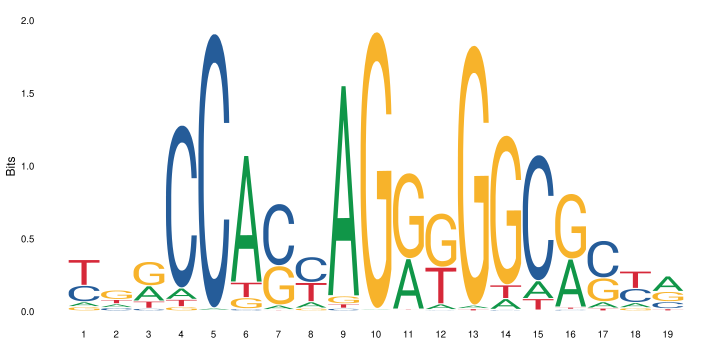

In [14]:
ctcf_path = "tf_motifs/CTCF"
display(SVG(os.path.join(ctcf_path, "ctcf.svg")))

We serached potential CTCF motif occurrences in TF ChIP-seq optimal IDR thresholded peak regions. The regions were originally stored as BigBed files, then converted in the corresponding BED files (with UCSC ```bigBedtoBed``` tool). The peak regions were obtained from different cell lines (A549, GM12878, HepG2, K562, MCF-7). Each BED file was filtered in order to keep only features related to the canonical chromosomes and sorted by *q*-value (9th column). Then, for each filtered and sorted BED we kept the first 3000 genomic regions (or rows).

The following table summarizes the used ChIP-seq optimal IDR thresholded peak regions, where we searched CTCF binding site motif on the 1000GP VG with GRAFIMO: 

| **Experiment code** | **Cell line** | **Scanned genomic regions** | **Genome assembly** |
| --- | --- | --- | --- |
| ENCFF816XLT | A549 | 3000 | hg38 |
| ENCFF267NYF | GM12878 | 3000 | hg38 |
| ENCFF015OJG | HepG2 | 3000 | hg38 |
| ENCFF895HAG | K562 | 3000 | hg38 |
| ENCFF088JWU | MCF-7 | 3000 | hg38 |

In [15]:
# read TSV reports (only significant motif occurrences)
grafimo_restable = "grafimo_out/grafimo_out.tsv"

encff816xlt = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_A549", grafimo_restable),
    sep="\t", index_col=0
)
encff816xlt["Experiment"] = ["ENCFF816XLT"] * len(encff816xlt)
encff816xlt["Cell_line"] = ["A549"] * len(encff816xlt)

encff267nyf = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_GM12878", grafimo_restable),
    sep="\t", index_col=0
)
encff267nyf["Experiment"] = ["ENCFF267NYF"] * len(encff267nyf)
encff267nyf["Cell_line"] = ["GM12878"] * len(encff267nyf)

encff015ojg = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_HepG2", grafimo_restable),
    sep="\t", index_col=0
)
encff015ojg["Experiment"] = ["ENCFF015OJG"] * len(encff015ojg)
encff015ojg["Cell_line"] = ["HepG2"] * len(encff015ojg)

encff895hag = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_K562", grafimo_restable),
    sep="\t", index_col=0
)
encff895hag["Experiment"] = ["ENCFF895HAG"] * len(encff895hag)
encff895hag["Cell_line"] = ["K562"] * len(encff895hag)

encff088jwu = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_MCF-7", grafimo_restable),
    sep="\t", index_col=0
)
encff088jwu["Experiment"] = ["ENCFF088JWU"] * len(encff088jwu)
encff088jwu["Cell_line"] = ["MCF-7"] * len(encff088jwu)

# put all the results in a single DataFrame
experiments = [encff816xlt, encff267nyf, encff015ojg, encff895hag, encff088jwu]
ctcf_df = pd.concat(experiments)
ctcf_df.reset_index(inplace=True, drop=True)
ctcf_df.head(n=10)

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,haplotype_frequency,reference,Experiment,Cell_line
0,MA0139.1,CTCF,chr2:231612642-231612803,231612720,231612739,+,29.114754,5.988800e-13,6.040843e-07,TGGCCACCAGGGGGCGCCG,5096,ref,ENCFF816XLT,A549
1,MA0139.1,CTCF,chr3:98023327-98023504,98023430,98023411,-,29.049180,8.440969e-13,6.040843e-07,CGGCCACCAGGGGGCGCCA,5096,ref,ENCFF816XLT,A549
2,MA0139.1,CTCF,chr7:98021604-98021781,98021693,98021712,+,28.983607,1.014121e-12,6.040843e-07,CGGCCACCAGGGGGCGCCG,5096,ref,ENCFF816XLT,A549
3,MA0139.1,CTCF,chr12:108618200-108618398,108618301,108618282,-,28.426230,4.089735e-12,1.218072e-06,CGGCCACCAGGGGGCGCCC,5096,ref,ENCFF816XLT,A549
4,MA0139.1,CTCF,chr16:67993308-67993508,67993402,67993421,+,28.426230,4.089735e-12,1.218072e-06,CGGCCACCAGGGGGCGCCC,5094,ref,ENCFF816XLT,A549
5,MA0139.1,CTCF,chr12:121499983-121500138,121500062,121500081,+,28.426230,4.089735e-12,1.218072e-06,CGGCCACCAGGGGGCGCCC,5096,ref,ENCFF816XLT,A549
6,MA0139.1,CTCF,chr8:142782577-142782754,142782661,142782680,+,28.327869,5.273880e-12,1.346360e-06,TGGCCACCAGGGGGCGCTC,2835,non.ref,ENCFF816XLT,A549
7,MA0139.1,CTCF,chr16:66608629-66608805,66608709,66608728,+,28.032787,1.198806e-11,2.380320e-06,TGGCCACCAGGTGGCGCCG,5088,ref,ENCFF816XLT,A549
8,MA0139.1,CTCF,chr1:156090811-156090991,156090877,156090896,+,28.032787,1.198806e-11,2.380320e-06,TGGCCACCAGGTGGCGCCG,5096,ref,ENCFF816XLT,A549
9,MA0139.1,CTCF,chr15:34210116-34210292,34210206,34210187,-,27.918033,1.594210e-11,2.559579e-06,TGGCCACCAGGGGGCACTG,787,non.ref,ENCFF816XLT,A549


In [16]:
# read TSV reports (all k-mers found on reference and haplotypes) -> k == motif.width
grafimo_all_restable = "grafimo_out_all/grafimo_out.tsv"

encff816xlt_all = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_A549", grafimo_all_restable),
    sep="\t", index_col=0
)

encff267nyf_all = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_GM12878", grafimo_all_restable),
    sep="\t", index_col=0
)

encff015ojg_all = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_HepG2", grafimo_all_restable),
    sep="\t", index_col=0
)

encff895hag_all = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_K562", grafimo_all_restable),
    sep="\t", index_col=0
)

encff088jwu_all = pd.read_csv(
    os.path.join(ctcf_path, "Cell_line_MCF-7", grafimo_all_restable),
    sep="\t", index_col=0
)

# put all k-mers (significant + non-significant) in a single DataFrame 
experiments_all = [
    encff816xlt_all, encff267nyf_all, encff015ojg_all, 
    encff895hag_all, encff088jwu_all
]
ctcf_df_all = pd.concat(experiments_all)
ctcf_df_all.reset_index(inplace=True, drop=True)
ctcf_df_all.head(n=10)

/Users/manuel/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,haplotype_frequency,reference
0,MA0139.1,CTCF,chr2:231612642-231612803,231612720,231612739,+,29.114754,5.988800e-13,6.040843e-07,TGGCCACCAGGGGGCGCCG,5096,ref
1,MA0139.1,CTCF,chr3:98023327-98023504,98023430,98023411,-,29.049180,8.440969e-13,6.040843e-07,CGGCCACCAGGGGGCGCCA,5096,ref
2,MA0139.1,CTCF,chr7:98021604-98021781,98021693,98021712,+,28.983607,1.014121e-12,6.040843e-07,CGGCCACCAGGGGGCGCCG,5096,ref
3,MA0139.1,CTCF,chr16:67993308-67993508,67993402,67993421,+,28.426230,4.089735e-12,1.218072e-06,CGGCCACCAGGGGGCGCCC,5094,ref
4,MA0139.1,CTCF,chr12:108618200-108618398,108618301,108618282,-,28.426230,4.089735e-12,1.218072e-06,CGGCCACCAGGGGGCGCCC,5096,ref
5,MA0139.1,CTCF,chr12:121499983-121500138,121500062,121500081,+,28.426230,4.089735e-12,1.218072e-06,CGGCCACCAGGGGGCGCCC,5096,ref
6,MA0139.1,CTCF,chr8:142782577-142782754,142782661,142782680,+,28.327869,5.273880e-12,1.346360e-06,TGGCCACCAGGGGGCGCTC,2835,non.ref
7,MA0139.1,CTCF,chr16:66608629-66608805,66608709,66608728,+,28.032787,1.198806e-11,2.380320e-06,TGGCCACCAGGTGGCGCCG,5088,ref
8,MA0139.1,CTCF,chr1:156090811-156090991,156090877,156090896,+,28.032787,1.198806e-11,2.380320e-06,TGGCCACCAGGTGGCGCCG,5096,ref
9,MA0139.1,CTCF,chr19:35067213-35067372,35067283,35067302,+,27.918033,1.594210e-11,2.559579e-06,TGGCCACCAGGGGGCACTG,5096,ref


### TFBS recovered in ChIP-seq peaks

The following plot shows the number of potential motif occurrences statistically significant (*P*-value $< 1e^ {-4}$) and non-significant found in the reference genome and haplotype sequences, scanning the 1000GP VG with GRAFIMO. We found several motif candidates in haplotype sequences, which are lost when scanning only the reference genome.

In [17]:
barplot_data_dict = dict()
experiments_names = ['ENCFF816XLT', 'ENCFF267NYF', 'ENCFF015OJG', 'ENCFF895HAG', 'ENCFF088JWU']
experiments = [encff816xlt_all, encff267nyf_all, encff015ojg_all, encff895hag_all, encff088jwu_all]

for i in range(len(experiments)):
    start = time.time()
    df = experiments[i]
    results = get_grouped_barplot_data(df)
    name = experiments_names[i]
    barplot_data_dict.update({name:results})
    end = time.time()
    print("%s analysis completed in:\t%.2fs"% (name, (end-start)))
    
barplot_data_dict

ENCFF816XLT analysis completed in:	0.32s
ENCFF267NYF analysis completed in:	0.28s
ENCFF015OJG analysis completed in:	0.31s
ENCFF895HAG analysis completed in:	0.31s
ENCFF088JWU analysis completed in:	0.31s


{'ENCFF816XLT': [4046, 2167, 913190, 569499],
 'ENCFF267NYF': [4176, 2247, 861314, 547421],
 'ENCFF015OJG': [3665, 1808, 992065, 591208],
 'ENCFF895HAG': [3452, 1773, 986878, 572458],
 'ENCFF088JWU': [3854, 2000, 994142, 597783]}

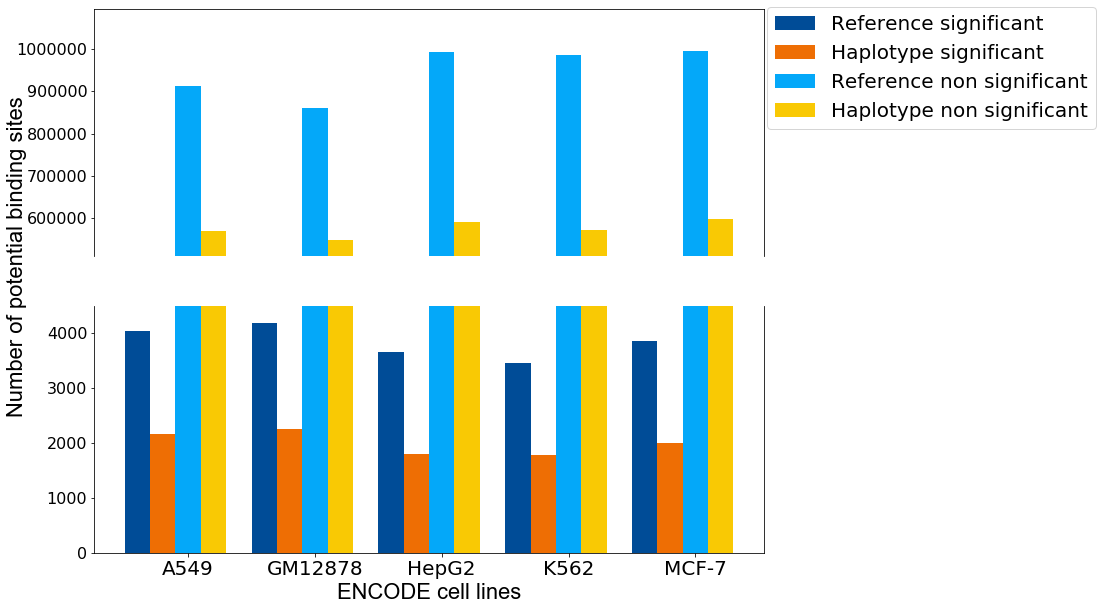

In [18]:
bs = 4500  # bottom breakpoint 
ts = 510000  # top breakpoint
cell_line_names = ['A549', 'GM12878', 'HepG2', 'K562', 'MCF-7']
loc = (1.005, 0.515)  # legend location
plot_grouped_barplot(barplot_data_dict, experiments_names, cell_line_names, bs, ts, loc)

### TFBS haplotype frequency in 1000GP

The following plot compares the frequency in haplotypes of statistically significant (*P*-value < 1e^{-4}) motif occurrence candidates found by GRAFIMO, with their *P*-values. We observed many potential CTCF motif occurrences with a highly statistically significant *P*-value occurring in a low number of haplotypes. These rare potential CTCF motif occurrences could modulate gene expression in those individuals differently with the other individuals. 

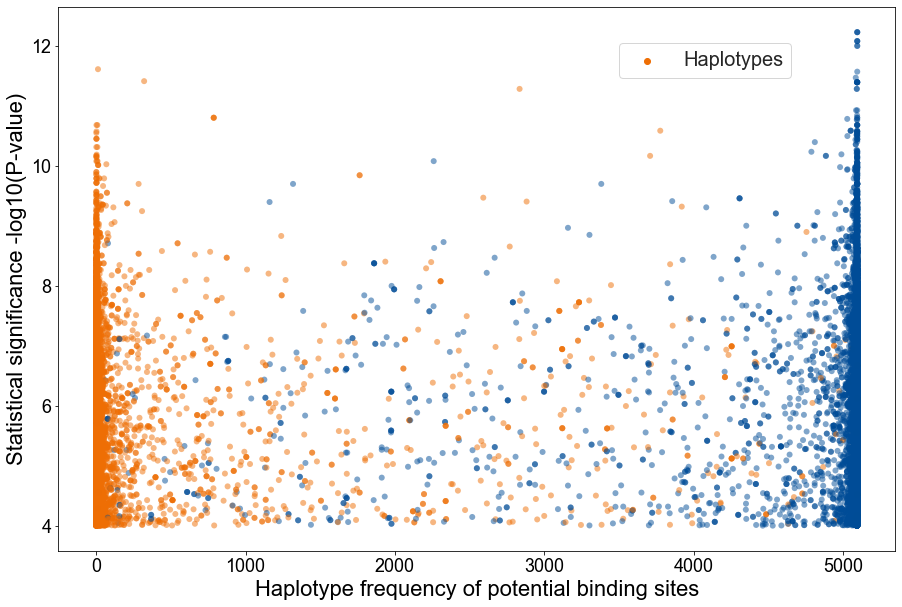

In [19]:
# convert P-values in log10(P-value)
ctcf_df["log_pvalue"] = ctcf_df.apply(lambda x : log10(x[7]), axis=1)
# add new labels (for plot displaying purposes only)
ctcf_df["Haplotype"] = ctcf_df.apply(lambda x : getHaplotypeFullName(x[11]), axis=1)

# define a color palette for dots in scatterplot
palette = ["#004c97", "#ee6e04"]
# define legend location
loc = (0.67, 0.87)
# plot data
plot_haplotype_freq(ctcf_df, palette, loc)

### TFBS across different categories based on genetic variants

The following plot shows that the 6.13% of the potential binding sites found scanning the 1000GP VG for CTCF potential motif occurrences are found only in haplotype sequences, the 5.94% of TFBS candidates found in the reference sequence are disrupted by genomic variants and ~30% are still significant, but with different binding score, due to the presence of genomic variants. The remaining 56.96% of retrieved CTCF TFBS candidates are found in the reference genome sequence.

In [20]:
# retrieve genomic coordinates for each binding site
ctcf_df_coords = ctcf_df
ctcf_df_all_coords = ctcf_df_all
start = time.time()
ctcf_df_coords["coords"] = ctcf_df_coords.apply(
    lambda x : get_coord(x[2], str(x[3]), str(x[4]), x[5]), axis=1
)
stop = time.time()
print("ctcf_df_coords computed in:\t%.2fs (%d elements)" % ((stop - start), len(ctcf_df_coords)))
# will take some time
start = time.time()
ctcf_df_all_coords["coords"] = ctcf_df_all_coords.apply(
    lambda x : get_coord(x[2], str(x[3]), str(x[4]), x[5]), axis=1
)
stop = time.time()
print("ctcf_df_all_coords computed in:\t%.2fs (%d elements)" % ((stop - start), len(ctcf_df_all_coords)))
pie_chart_data, ref_tfbs, hap_bs, enha_bs, weak_bs = get_tfbs_class(ctcf_df_coords)
disr_refbs, disr_bs = get_disrupted_tfbs(ctcf_df_all_coords, ref_tfbs)
pie_chart_data = [pie_chart_data[0]] + [disr_refbs] + pie_chart_data[1:]

ctcf_df_coords computed in:	1.16s (29188 elements)
ctcf_df_all_coords computed in:	261.09s (7655146 elements)
Classifying 29188 motif occurrences...
Classified 29188 motif occurrences in:	30.73s
Analyzing 9651 binding sites...
Analyzed 9651 binding sites in:	8.28s


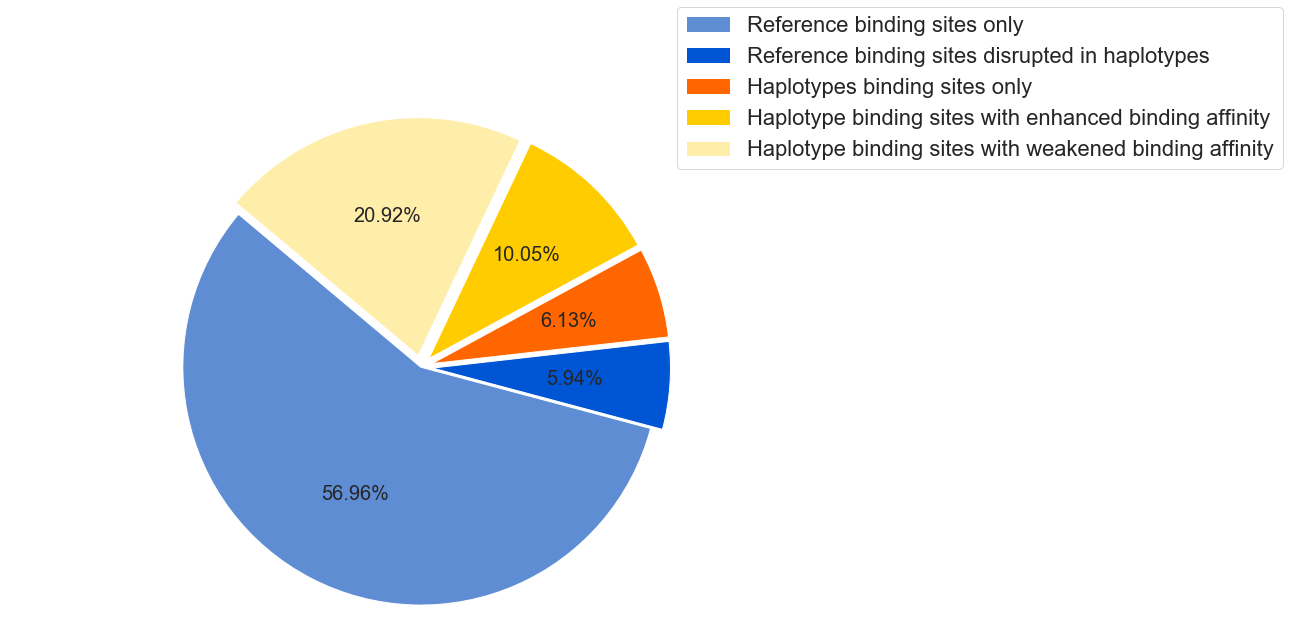

In [21]:
plot_pie(pie_chart_data)

### Assessing SNP and indels effects on binding affinity

The following plot show the effect of SNP and indels on potential CTCF motif occurrences statistically significant (*P*-value $< 1e^{-4}$) retrieved on individual haplotype sequences. We observe no specific trend on how indels affect binding affinity scores for potential CTCF motif occurrences.

In [22]:
ctcf_df_hap = ctcf_df_coords[ctcf_df_coords.reference == "non.ref"].reset_index(drop=True)
ctcf_df_hap["vtype"] = ctcf_df_hap.apply(lambda x : computeVariantType(x[3], x[4], x[11], 19, 3), axis=1)
ctcf_df_hap.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,haplotype_frequency,reference,Experiment,Cell_line,log_pvalue,Haplotype,coords,vtype
0,MA0139.1,CTCF,chr8:142782577-142782754,142782661,142782680,+,28.327869,5.273880e-12,0.000001,TGGCCACCAGGGGGCGCTC,2835,non.ref,ENCFF816XLT,A549,11.277870,Haplotypes,chr8_142782661_142782680_+,SNP
1,MA0139.1,CTCF,chr15:34210116-34210292,34210206,34210187,-,27.918033,1.594210e-11,0.000003,TGGCCACCAGGGGGCACTG,787,non.ref,ENCFF816XLT,A549,10.797454,Haplotypes,chr15_34210206_34210187_-,SNP
2,MA0139.1,CTCF,chr16:66608629-66608805,66608709,66608728,+,27.803279,2.111354e-11,0.000003,TGGCCACCAGGTGGCGCTG,8,non.ref,ENCFF816XLT,A549,10.675439,Haplotypes,chr16_66608709_66608728_+,SNP
3,MA0139.1,CTCF,chr10:123994704-123994883,123994783,123994802,+,27.491803,3.572712e-11,0.000003,TGGCCACCAGGGGGCAGCG,2,non.ref,ENCFF816XLT,A549,10.447002,Haplotypes,chr10_123994783_123994802_+,SNP
4,MA0139.1,CTCF,chr10:123994704-123994883,123994783,123994802,+,27.131148,7.240292e-11,0.000005,CGGCCACCAGGGGGCAGTG,2,non.ref,ENCFF816XLT,A549,10.140244,Haplotypes,chr10_123994783_123994802_+,SNP


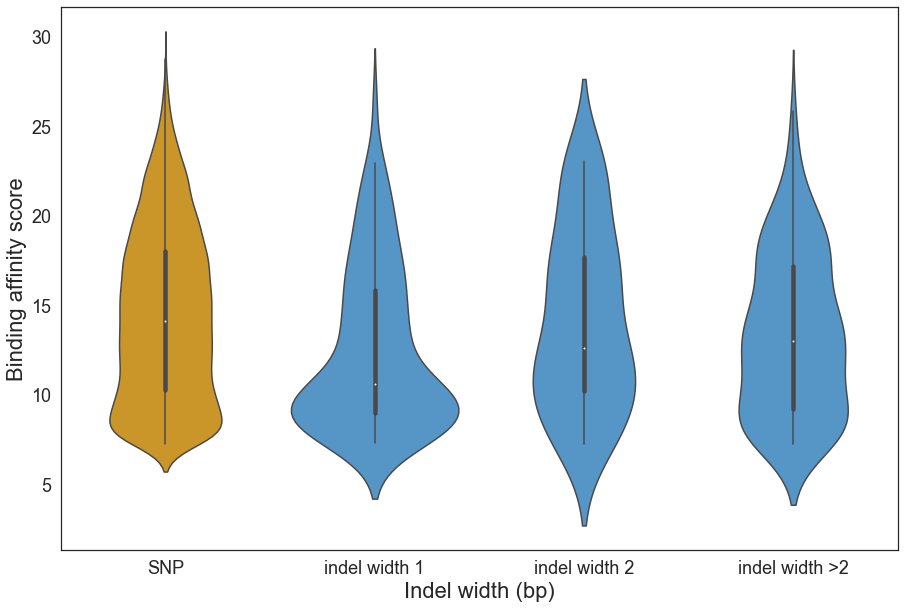

In [23]:
palette = [
    "#E5A00E",
    "#4399D9",
    "#4399D9",
    "#4399D9",
    "#4399D9",
    "#4399D9",
    "#4399D9"
]
plot_violin(ctcf_df_hap, palette)

## ATF3

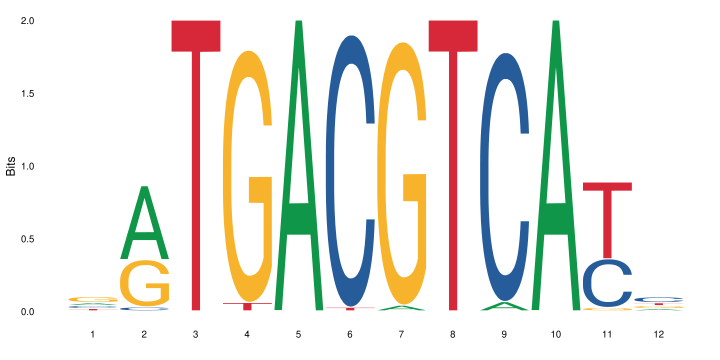

In [24]:
atf3_path = "tf_motifs/ATF3"
display(SVG(os.path.join(atf3_path, "atf3.svg")))

We serached potential ATF3 binding site occurrences TF ChIP-seq optimal IDR thresholded peak regions from the ENCODE Project data portal. The peak regions were obtained from different cell lines (H1, HepG2, K562). Each BED file containing the target genomic regions was filtered in order to keep only features related to the canonical chromosomes and sorted by *q*-value. Then, for each filtered and sorted BED we kept the first 3000 genomic regions.

The following table summarizes the used ChIP-seq optimal IDR thresholded peak regions, where we searched ATF3 motif on the 1000GP VG with GRAFIMO: 


| **Experiment code** | **Cell line** | **Scanned genomic regions** | **Genome assembly** |
| --- | --- | --- | --- |
| ENCFF207AVV | H1 | 3000 | hg38 |
| ENCFF753WNT | HepG2 | 3000 | hg38 |
| ENCFF787GVU | K562 | 3000 | hg38 |

In [25]:
# read TSV reports (only significant motif occurrences)
grafimo_restable = "grafimo_out/grafimo_out.tsv"

encff207avv = pd.read_csv(
    os.path.join(atf3_path, "Cell_line_H1", grafimo_restable),
    sep="\t", index_col=0
)
encff207avv['Experiment'] = ['ENCFF207AVV'] * len(encff207avv)
encff207avv['Cell_line'] = ['H1'] * len(encff207avv)

encff753wnt = pd.read_csv(
    os.path.join(atf3_path, "Cell_line_HepG2", grafimo_restable),
    sep="\t", index_col=0
)
encff753wnt['Experiment'] = ['ENCFF753WNT'] * len(encff753wnt)
encff753wnt['Cell_line'] = ['HepG2'] * len(encff753wnt)

encff787gvu = pd.read_csv(
    os.path.join(atf3_path, "Cell_line_K562", grafimo_restable),
    sep="\t", index_col=0
)
encff787gvu['Experiment'] = ['ENCFF787GVU'] * len(encff787gvu)
encff787gvu['Cell_line'] = ['K562'] * len(encff787gvu)

# put all the results in a single DataFrame
experiments = [encff207avv, encff753wnt, encff787gvu]
atf3_df = pd.concat(experiments)
atf3_df.reset_index(inplace=True, drop=True)
atf3_df.head(n=10)

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,haplotype_frequency,reference,Experiment,Cell_line
0,MA0605.2,ATF3,chr9:97922178-97922386,97922240,97922228,-,20.12766,4.879815e-08,0.01316,GATGACGTCATC,5096,ref,ENCFF207AVV,H1
1,MA0605.2,ATF3,chr9:97922178-97922386,97922228,97922240,+,20.12766,4.879815e-08,0.01316,GATGACGTCATC,5096,ref,ENCFF207AVV,H1
2,MA0605.2,ATF3,chr12:132446083-132446323,132446323,132446311,-,20.00000,1.164678e-07,0.01316,GGTGACGTCATC,5093,ref,ENCFF207AVV,H1
3,MA0605.2,ATF3,chr7:100867167-100867407,100867324,100867336,+,20.00000,1.164678e-07,0.01316,GGTGACGTCATC,5086,ref,ENCFF207AVV,H1
4,MA0605.2,ATF3,chr7:100867167-100867407,100867336,100867324,-,20.00000,1.164678e-07,0.01316,GATGACGTCACC,5086,ref,ENCFF207AVV,H1
5,MA0605.2,ATF3,chr12:132446083-132446323,132446109,132446121,+,20.00000,1.164678e-07,0.01316,GATGACGTCACC,4902,ref,ENCFF207AVV,H1
6,MA0605.2,ATF3,chr12:132446083-132446323,132446210,132446222,+,20.00000,1.164678e-07,0.01316,GATGACGTCACC,5096,ref,ENCFF207AVV,H1
7,MA0605.2,ATF3,chr12:132446083-132446323,132446121,132446109,-,20.00000,1.164678e-07,0.01316,GGTGACGTCATC,4902,ref,ENCFF207AVV,H1
8,MA0605.2,ATF3,chr9:94726562-94726802,94726677,94726665,-,20.00000,1.164678e-07,0.01316,GGTGACGTCATC,5095,ref,ENCFF207AVV,H1
9,MA0605.2,ATF3,chr12:132446083-132446323,132446222,132446210,-,20.00000,1.164678e-07,0.01316,GGTGACGTCATC,5096,ref,ENCFF207AVV,H1


In [26]:
# read TSV reports (all k-mers found on reference and haplotypes) -> k == motif.width
grafimo_all_restable = "grafimo_out_all/grafimo_out.tsv"
encff207avv_all = pd.read_csv(
    os.path.join(atf3_path, "Cell_line_H1", grafimo_all_restable),
    sep="\t", index_col=0
)

encff753wnt_all = pd.read_csv(
    os.path.join(atf3_path, "Cell_line_HepG2", grafimo_all_restable),
    sep="\t", index_col=0
)

encff787gvu_all = pd.read_csv(
    os.path.join(atf3_path, "Cell_line_K562", grafimo_all_restable),
    sep="\t", index_col=0
)

# put all k-mers (signifcant + non-significant) in a single DataFrame
experiments_all = [encff207avv_all, encff753wnt_all, encff787gvu_all]
atf3_df_all = pd.concat(experiments_all)
atf3_df_all.reset_index(inplace=True, drop=True)
atf3_df_all.head(n=10)

/Users/manuel/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,haplotype_frequency,reference
0,MA0605.2,ATF3,chr9:97922178-97922386,97922228,97922240,+,20.12766,4.879815e-08,0.01316,GATGACGTCATC,5096,ref
1,MA0605.2,ATF3,chr9:97922178-97922386,97922240,97922228,-,20.12766,4.879815e-08,0.01316,GATGACGTCATC,5096,ref
2,MA0605.2,ATF3,chr7:100867167-100867407,100867336,100867324,-,20.00000,1.164678e-07,0.01316,GATGACGTCACC,5086,ref
3,MA0605.2,ATF3,chr12:132446083-132446323,132446109,132446121,+,20.00000,1.164678e-07,0.01316,GATGACGTCACC,4902,ref
4,MA0605.2,ATF3,chr3:124730316-124730556,124730402,124730414,+,20.00000,1.164678e-07,0.01316,GGTGACGTCATC,2746,ref
5,MA0605.2,ATF3,chr12:132446083-132446323,132446210,132446222,+,20.00000,1.164678e-07,0.01316,GATGACGTCACC,5096,ref
6,MA0605.2,ATF3,chr12:132446083-132446323,132446121,132446109,-,20.00000,1.164678e-07,0.01316,GGTGACGTCATC,4902,ref
7,MA0605.2,ATF3,chr12:132446083-132446323,132446261,132446273,+,20.00000,1.164678e-07,0.01316,GATGACGTCACC,5096,ref
8,MA0605.2,ATF3,chr12:132446083-132446323,132446222,132446210,-,20.00000,1.164678e-07,0.01316,GGTGACGTCATC,5096,ref
9,MA0605.2,ATF3,chr12:132446083-132446323,132446273,132446261,-,20.00000,1.164678e-07,0.01316,GGTGACGTCATC,5096,ref


### TFBS recovered in ChIP-seq peaks 

The following plot shows the number of potential ATF3 motif occurrences statistically significant (*P*-value $< 1e^{-4}$) and non-significant found in the reference genome and haplotype sequences. We found several motif candidates in haplotype sequences, which are lost when scanning only the reference genome.

In [27]:
barplot_data_dict = dict()
experiments_names = ["ENCFF207AVV", "ENCFF753WNT", "ENCFF787GVU"]
experiments = [encff207avv_all, encff753wnt_all, encff787gvu_all]

for i in range(len(experiments)):
    start = time.time()
    df = experiments[i]
    results = get_grouped_barplot_data(df)
    name = experiments_names[i]
    barplot_data_dict.update({name:results})
    end = time.time()
    print("%s analysis completed in:\t%.2fs"% (name, (end-start)))
    
barplot_data_dict

ENCFF207AVV analysis completed in:	0.35s
ENCFF753WNT analysis completed in:	0.29s
ENCFF787GVU analysis completed in:	0.33s


{'ENCFF207AVV': [556, 161, 1309751, 563991],
 'ENCFF753WNT': [476, 142, 1256238, 544372],
 'ENCFF787GVU': [845, 220, 1366845, 650393]}

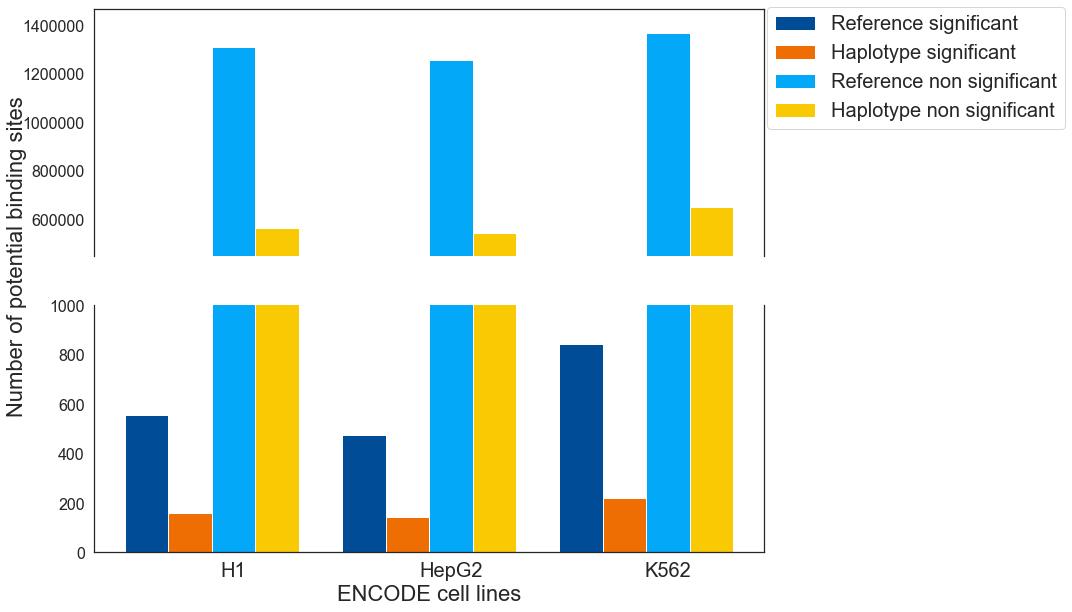

In [28]:
bs = 1000  # bottom breakpoint
ts = 450000  # top breakpoint
cell_line_names = ['H1', 'HepG2', 'K562']
loc=(1.005, 0.515)  # legend location
plot_grouped_barplot(barplot_data_dict, experiments_names, cell_line_names, bs, ts, loc)

### TFBS haplotype frequency in 1000GP

The following plot compares the frequency in haplotypes of statistically significant (*P*-value $< 1e^{-4}$) ATF3 motif occurrence candidates with their *P*-values. We observed that several potential motif occurrences have a highly statistically significant *P*-value occurring in a low number of haplotypes.

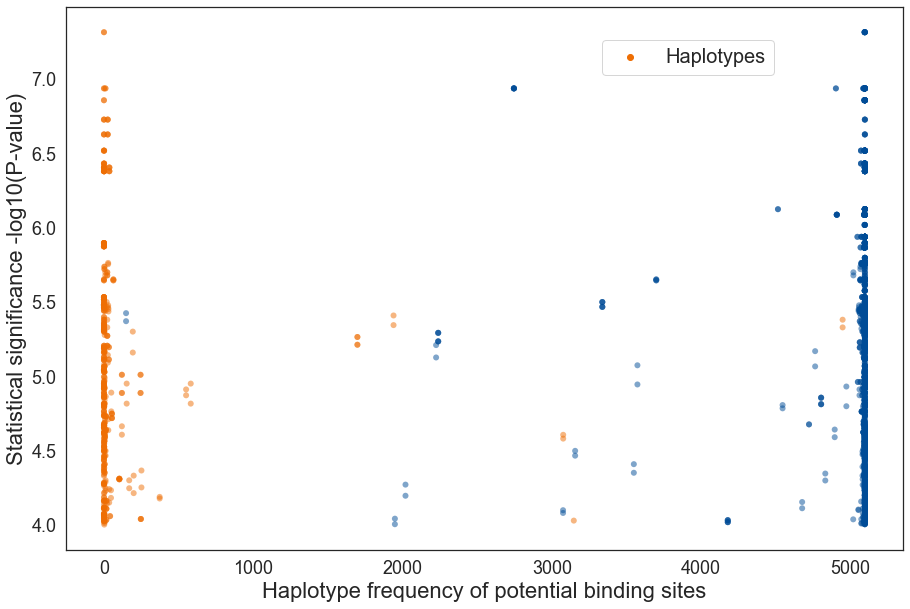

In [29]:
# convert P-values in log10(P-value)
atf3_df["log_pvalue"] = atf3_df.apply(lambda x : log10(x[7]), axis=1)
# add new labels (for plot displaying purposes only)
atf3_df["Haplotype"] = atf3_df.apply(lambda x : getHaplotypeFullName(x[11]), axis=1)

# define a color palette for dots in scatterplot
palette = ["#004c97", "#ee6e04"]
# define legend location
loc=(0.64, 0.875)
# plot data
plot_haplotype_freq(atf3_df, palette, loc)

### TFBS across different categories based on genetic variants

The pie chart shows that the 7.03% of the retrieved potential binding sites can be found only in haplotype sequences, the 11.28% of TFBS candidates found in the reference genome are disrupted by genomic variants and ~13% are still significant, but with a different binding score. The remaining 67.95% of retrieved CTCF TFBS candidates are found in the reference genome sequence.

In [30]:
# retrieve genomic coordinates for each binding site
atf3_df_coords = atf3_df
atf3_df_all_coords = atf3_df_all
start = time.time()
atf3_df_coords["coords"] = atf3_df_coords.apply(
    lambda x : get_coord(x[2], str(x[3]), str(x[4]), x[5]), axis=1
)
stop = time.time()
print("atf3_df_coords computed in:\t%.2fs (%d elements)" % ((stop - start), len(atf3_df_coords)))
# will take some time
start = time.time()
atf3_df_all_coords["coords"] = atf3_df_all_coords.apply(
    lambda x : get_coord(x[2], str(x[3]), str(x[4]), x[5]), axis=1
)
stop = time.time()
print("atf3_df_all_coords computed in:\t%.2fs (%d elements)" % ((stop - start), len(atf3_df_all_coords)))
pie_chart_data, ref_tfbs, hap_bs, enha_bs, weak_bs = get_tfbs_class(atf3_df_coords)
disr_refbs, disr_bs = get_disrupted_tfbs(atf3_df_all_coords, ref_tfbs)
pie_chart_data = [pie_chart_data[0]] + [disr_refbs] + pie_chart_data[1:]

atf3_df_coords computed in:	0.10s (2400 elements)
atf3_df_all_coords computed in:	190.99s (5693990 elements)
Classifying 2400 motif occurrences...
Classified 2400 motif occurrences in:	1.02s
Analyzing 1024 binding sites...
Analyzed 1024 binding sites in:	5.74s


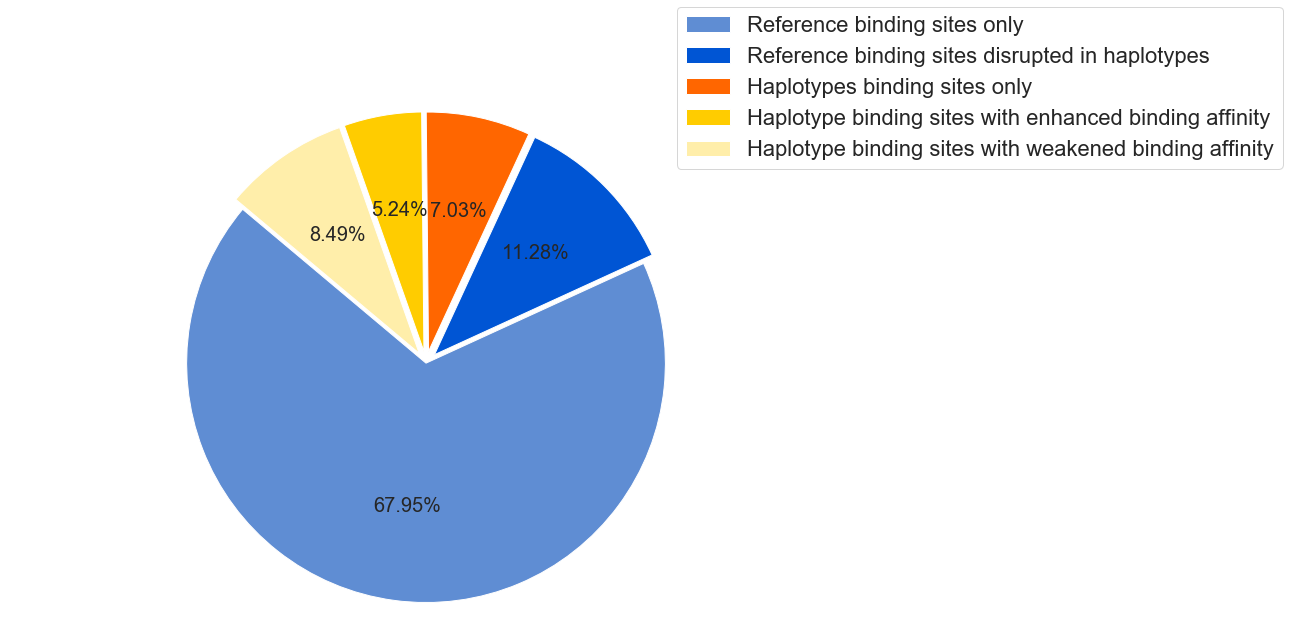

In [31]:
plot_pie(pie_chart_data)

### Assessing SNP and indels effects on binding affinity

The following plot show the effect of SNP and indels on potential ATF3 motif occurrences statistically significant (*P*-value $< 1e^{-4}$) retrieved in individual haplotypes. We observe no specific trend on how indels affect binding affinity scores for potential ATF3 motif occurrences.

In [32]:
atf3_df_hap = atf3_df_coords[atf3_df_coords.reference == "non.ref"].reset_index(drop=True)
atf3_df_hap["vtype"] = atf3_df_hap.apply(lambda x : computeVariantType(x[3], x[4], x[11], 12, 3), axis=1)
atf3_df_hap.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,haplotype_frequency,reference,Experiment,Cell_line,log_pvalue,Haplotype,coords,vtype
0,MA0605.2,ATF3,chr11:77474266-77474506,77474399,77474411,+,20.000000,1.164678e-07,0.01316,GGTGACGTCATC,1,non.ref,ENCFF207AVV,H1,6.933794,Haplotypes,chr11_77474399_77474411_+,SNP
1,MA0605.2,ATF3,chr11:77474266-77474506,77474411,77474399,-,20.000000,1.164678e-07,0.01316,GATGACGTCACC,1,non.ref,ENCFF207AVV,H1,6.933794,Haplotypes,chr11_77474411_77474399_-,SNP
2,MA0605.2,ATF3,chr19:17932935-17933075,17933003,17933015,+,19.106383,1.887258e-07,0.01316,GATGACGTCATG,1,non.ref,ENCFF207AVV,H1,6.724169,Haplotypes,chr19_17933003_17933015_+,SNP
3,MA0605.2,ATF3,chr17:35587193-35587283,35587233,35587245,+,19.106383,1.887258e-07,0.01316,GATGACGTCATG,26,non.ref,ENCFF207AVV,H1,6.724169,Haplotypes,chr17_35587233_35587245_+,SNP
4,MA0605.2,ATF3,chr19:17932935-17933075,17933015,17933003,-,19.085106,2.375240e-07,0.01316,CATGACGTCATC,1,non.ref,ENCFF207AVV,H1,6.624293,Haplotypes,chr19_17933015_17933003_-,SNP


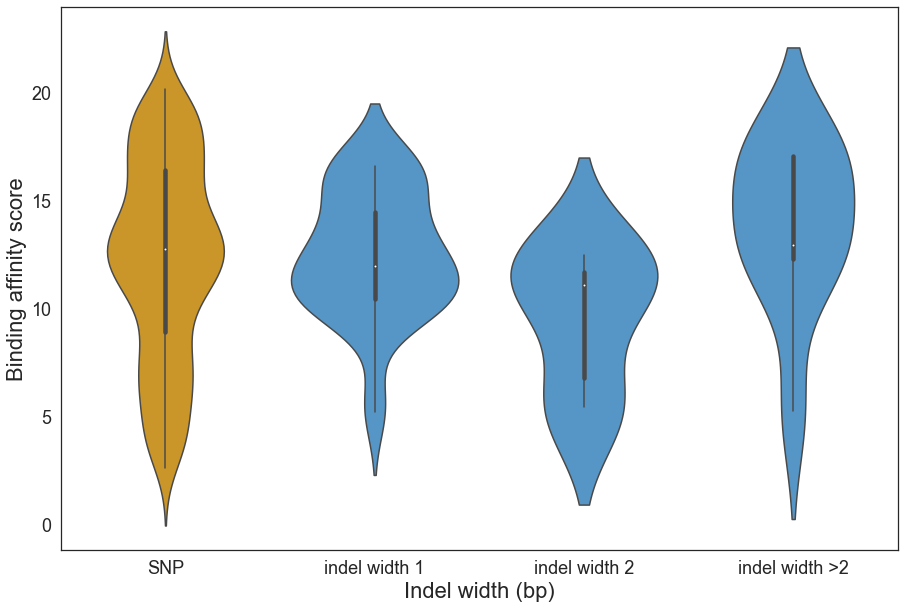

In [33]:
palette = [
    "#E5A00E",
    "#4399D9",
    "#4399D9",
    "#4399D9",
    "#4399D9",
    "#4399D9",
    "#4399D9"
]
plot_violin(atf3_df_hap, palette)

## GATA1

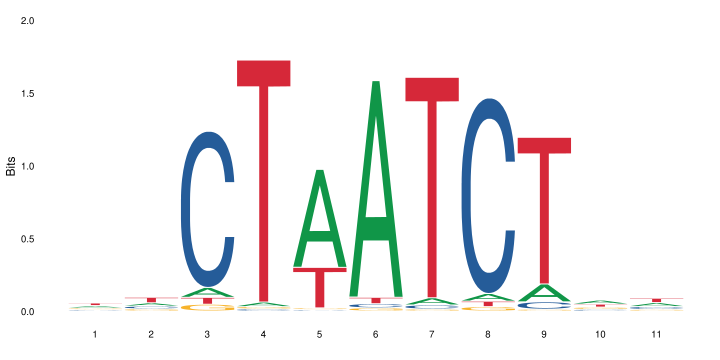

In [34]:
gata1_path = "tf_motifs/GATA1"
display(SVG(os.path.join(gata1_path, "gata1.svg")))

GATA1 TFBS motif has been searched in TF ChIP-seq optimal IDR thresholded peak regions. The peak regions were obtained from different experiments performed on cell lines K562. Each BED file containing the considered genomic regions was filtered in order to keep only features related to the canonical chromosomes and sorted by *q*-value. For each filtered and sorted BED we kept the first 3000 genomic regions.

The following table summarizes the used ChIP-seq optimal IDR thresholded peak regions, where we searched GATA1 motif on the 1000GP VG with GRAFIMO: 


| **Experiment code** | **Cell line** | **Scanned genomic regions** | **Genome assembly** |
| --- | --- | --- | --- |
| ENCFF939ODZ | K562 | 3000 | hg38 |
| ENCFF811YFQ | K562 | 3000 | hg38 |

In [35]:
# read TSV reports (only significant motif occurrences)
encff939odz = pd.read_csv(
    os.path.join(gata1_path, "Cell_line_K562/grafimo_out_ENCFF939ODZ/grafimo_out.tsv"),
    sep="\t", index_col=0
)
encff939odz['Experiment'] = ['ENCFF939ODZ'] * len(encff939odz)
encff939odz['Cell_line'] = ['K562'] * len(encff939odz)

encff811yfq = pd.read_csv(
    os.path.join(gata1_path, "Cell_line_K562/grafimo_out_ENCFF811YFQ/grafimo_out.tsv"),
    sep="\t", index_col=0
)
encff811yfq['Experiment'] = ['ENCFF811YFQ'] * len(encff811yfq)
encff811yfq['Cell_line'] = ['K562'] * len(encff811yfq)

# put all the results in a single DataFrame
experiments = [encff939odz, encff811yfq]
gata1_df = pd.concat(experiments)
gata1_df.reset_index(inplace=True, drop=True)
gata1_df.head(n=10)

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,haplotype_frequency,reference,Experiment,Cell_line
0,MA0035.4,GATA1,chr3:87796148-87796398,87796234,87796223,-,13.100719,0.000001,0.146171,ATCTAATCTAT,5096,ref,ENCFF939ODZ,K562
1,MA0035.4,GATA1,chr7:134834959-134835173,134835045,134835056,+,13.100719,0.000001,0.146171,ATCTAATCTAT,5096,ref,ENCFF939ODZ,K562
2,MA0035.4,GATA1,chr8:11016826-11017076,11016988,11016977,-,13.100719,0.000001,0.146171,ATCTAATCTAT,5096,ref,ENCFF939ODZ,K562
3,MA0035.4,GATA1,chr2:135698955-135699205,135699012,135699002,-,13.100719,0.000001,0.146171,ATCTAATCTAT,9,non.ref,ENCFF939ODZ,K562
4,MA0035.4,GATA1,chr2:135698955-135699205,135699058,135699047,-,13.100719,0.000001,0.146171,ATCTAATCTAT,779,non.ref,ENCFF939ODZ,K562
5,MA0035.4,GATA1,chr2:135698955-135699205,135699109,135699098,-,13.100719,0.000001,0.146171,ATCTAATCTAT,4435,ref,ENCFF939ODZ,K562
6,MA0035.4,GATA1,chr2:135698955-135699205,135699084,135699069,-,13.100719,0.000001,0.146171,ATCTAATCTAT,265,non.ref,ENCFF939ODZ,K562
7,MA0035.4,GATA1,chr2:135698955-135699205,135699080,135699069,-,13.100719,0.000001,0.146171,ATCTAATCTAT,3417,ref,ENCFF939ODZ,K562
8,MA0035.4,GATA1,chr10:80662658-80662908,80662745,80662756,+,13.100719,0.000001,0.146171,ATCTAATCTAT,5096,ref,ENCFF939ODZ,K562
9,MA0035.4,GATA1,chr2:135698955-135699205,135699028,135699018,-,13.100719,0.000001,0.146171,ATCTAATCTAT,22,non.ref,ENCFF939ODZ,K562


In [36]:
# read TSV reports (all k-mers found on reference and haplotypes) -> k == motif.width
encff939odz_all = pd.read_csv(
    os.path.join(gata1_path, "Cell_line_K562/grafimo_out_all_ENCFF939ODZ/grafimo_out.tsv"),
    sep="\t", index_col=0
)

encff811yfq_all = pd.read_csv(
    os.path.join(gata1_path, "Cell_line_K562/grafimo_out_all_ENCFF811YFQ/grafimo_out.tsv"),
    sep="\t", index_col=0
)

# put all k-mers (signifcant + non-significant) in a single DataFrame
experiments_all = [encff939odz_all, encff811yfq_all]
gata1_df_all = pd.concat(experiments_all)
gata1_df_all.reset_index(inplace=True, drop=True)
gata1_df_all.head(n=10)

/Users/manuel/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,haplotype_frequency,reference
0,MA0035.4,GATA1,chr2:135698955-135699205,135699058,135699047,-,13.100719,0.000001,0.146171,ATCTAATCTAT,779,non.ref
1,MA0035.4,GATA1,chr2:135698955-135699205,135699084,135699069,-,13.100719,0.000001,0.146171,ATCTAATCTAT,265,non.ref
2,MA0035.4,GATA1,chr8:11016826-11017076,11016988,11016977,-,13.100719,0.000001,0.146171,ATCTAATCTAT,5096,ref
3,MA0035.4,GATA1,chr2:135698955-135699205,135699109,135699098,-,13.100719,0.000001,0.146171,ATCTAATCTAT,4435,ref
4,MA0035.4,GATA1,chr3:87796148-87796398,87796234,87796223,-,13.100719,0.000001,0.146171,ATCTAATCTAT,5096,ref
5,MA0035.4,GATA1,chr2:135698955-135699205,135699012,135699002,-,13.100719,0.000001,0.146171,ATCTAATCTAT,9,non.ref
6,MA0035.4,GATA1,chr7:134834959-134835173,134835045,134835056,+,13.100719,0.000001,0.146171,ATCTAATCTAT,5096,ref
7,MA0035.4,GATA1,chr10:80662658-80662908,80662745,80662756,+,13.100719,0.000001,0.146171,ATCTAATCTAT,5096,ref
8,MA0035.4,GATA1,chr2:135698955-135699205,135699080,135699069,-,13.100719,0.000001,0.146171,ATCTAATCTAT,3417,ref
9,MA0035.4,GATA1,chr2:135698955-135699205,135699028,135699018,-,13.100719,0.000001,0.146171,ATCTAATCTAT,22,non.ref


### TFBS recovered in ChIP-seq peaks

The following plot shows the number of GATA1 motif candidates statistically significant (*P*-value $ < 1e-4$) and non-significant found in the reference genome and haplotype sequences. We found many potential motif occurrences in haplotype sequences, which are lost when scanning only the reference genome.

In [37]:
barplot_data_dict = dict()
experiments_names = ["ENCFF811YFQ", "ENCFF939ODZ"]
experiments = [encff811yfq_all, encff939odz_all]

for i in range(len(experiments)):
    start = time.time()
    df = experiments[i]
    results = get_grouped_barplot_data(df)
    name = experiments_names[i]
    barplot_data_dict.update({name:results})
    end = time.time()
    print("%s analysis completed in:\t%.2fs"% (name, (end-start)))
    
barplot_data_dict

ENCFF811YFQ analysis completed in:	0.37s
ENCFF939ODZ analysis completed in:	0.24s


{'ENCFF811YFQ': [302, 52, 1615324, 555627],
 'ENCFF939ODZ': [446, 86, 1155446, 365892]}

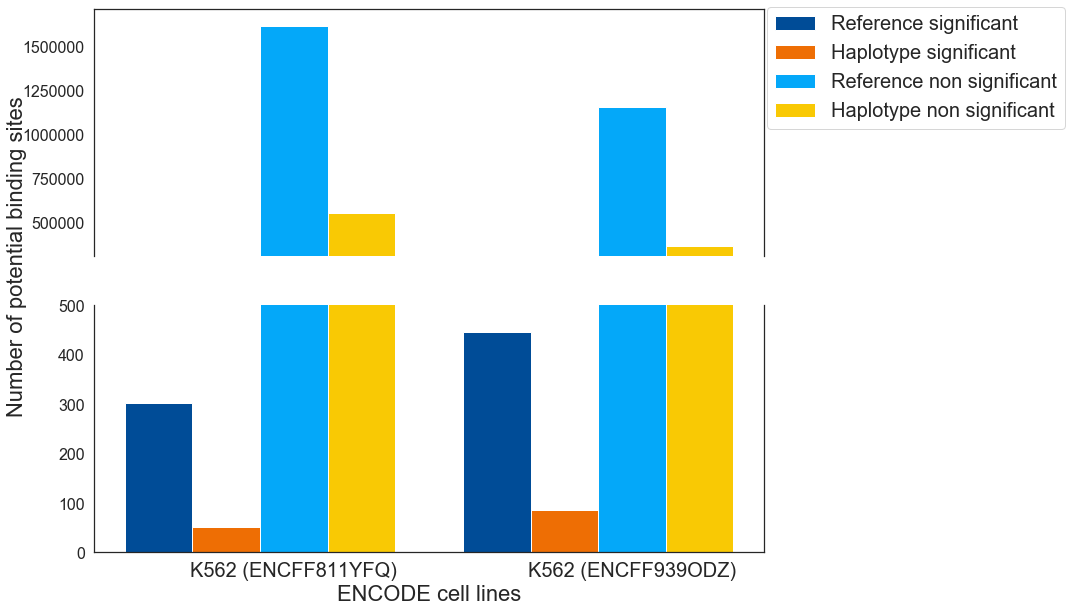

In [38]:
bs = 500  # bottom breakpoint 
ts = 310000  # top breakpoint
cell_line_names = ['K562 (ENCFF811YFQ)', 'K562 (ENCFF939ODZ)']
loc=(1.005, 0.515)  # legend location
plot_grouped_barplot(barplot_data_dict, experiments_names, cell_line_names, bs, ts, loc)

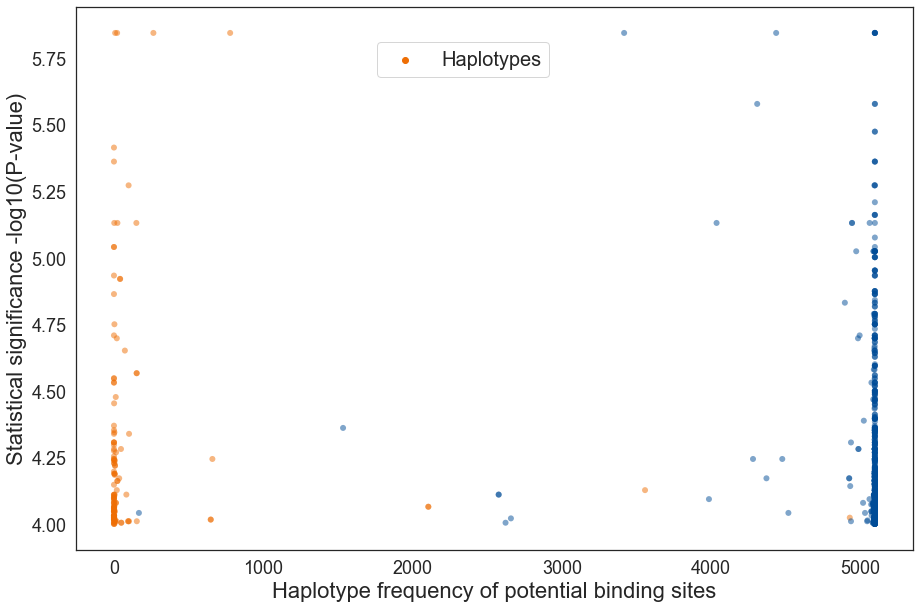

In [39]:
# convert P-values in log10(P-value)
gata1_df["log_pvalue"] = gata1_df.apply(lambda x : log10(x[7]), axis=1)
# add new labels (for plot displaying purposes only)
gata1_df["Haplotype"] = gata1_df.apply(lambda x : getHaplotypeFullName(x[11]), axis=1)

# define a color palette for dots in scatterplot
palette = ["#004c97", "#ee6e04"]
# define legend location
loc=(0.36, 0.87)
# plot data
plot_haplotype_freq(gata1_df, palette, loc)

### TFBS across different categories based on genetic variants

The plot shows that the 9.78% of the retrieved potential binding sites can be found only in haplotype sequences, the 12.58% of the GATA1 TFBS found in the reference genome are disrupted by genomic variants and ~4% of the potential binding sites have a different binding score, but are still statistically significant (*P*-value $< 1e^{-4}$). The remaining 73.19% of retrieved CTCF TFBS candidates are found in the reference genome sequence.

In [40]:
# retrieve genomic coordinates for each binding site
gata1_df_coords = gata1_df
gata1_df_all_coords = gata1_df_all
start = time.time()
gata1_df_coords["coords"] = gata1_df_coords.apply(
    lambda x : get_coord(x[2], str(x[3]), str(x[4]), x[5]), axis=1
)
stop = time.time()
print("gata1_df_coords computed in:\t%.2fs (%d elements)" % ((stop - start), len(gata1_df_coords)))
# will take some time
start = time.time()
gata1_df_all_coords["coords"] = gata1_df_all_coords.apply(
    lambda x : get_coord(x[2], str(x[3]), str(x[4]), x[5]), axis=1
)
stop = time.time()
print("gata1_df_all_coords computed in:\t%.2fs (%d elements)" % ((stop - start), len(gata1_df_all_coords)))
pie_chart_data, ref_tfbs, hap_bs, enha_bs, weak_bs = get_tfbs_class(gata1_df_coords)
disr_refbs, disr_bs = get_disrupted_tfbs(gata1_df_all_coords, ref_tfbs)
pie_chart_data = [pie_chart_data[0]] + [disr_refbs] + pie_chart_data[1:]

gata1_df_coords computed in:	0.03s (886 elements)
gata1_df_all_coords computed in:	123.96s (3693175 elements)
Classifying 886 motif occurrences...
Classified 886 motif occurrences in:	0.47s
Analyzing 576 binding sites...
Analyzed 576 binding sites in:	3.75s


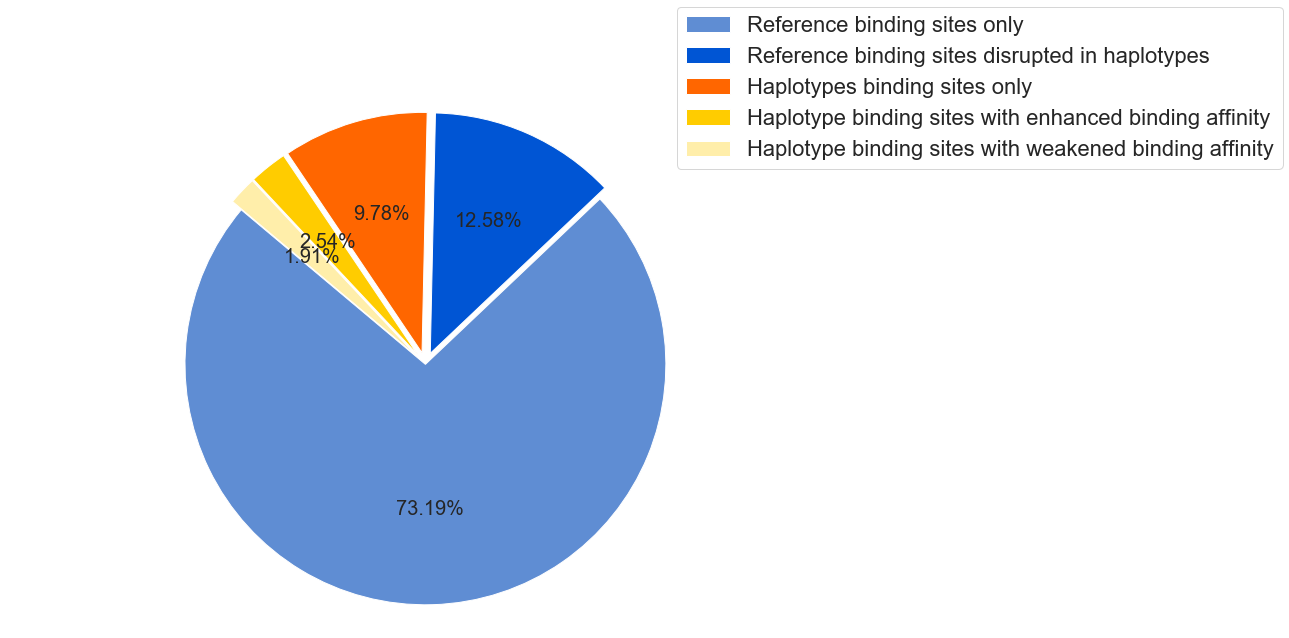

In [41]:
plot_pie(pie_chart_data)

### Assessing SNP and indels effects on binding affinity

The following plot show the effect of SNP and indels on potential GATA1 occurrences statistically significant (*P*-value $< 1e^{-4}$) retrieved accounting for individual genetic variation. We observe no specific trend on how indels affect binding affinity scores also for potential GATA1 motif occurrences.

In [42]:
gata1_df_hap = gata1_df_coords[gata1_df_coords.reference == "non.ref"].reset_index(drop=True)
gata1_df_hap["vtype"] = gata1_df_hap.apply(lambda x : computeVariantType(x[3], x[4], x[11], 11, 3), axis=1)
gata1_df_hap.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,haplotype_frequency,reference,Experiment,Cell_line,log_pvalue,Haplotype,coords,vtype
0,MA0035.4,GATA1,chr2:135698955-135699205,135699012,135699002,-,13.100719,0.000001,0.146171,ATCTAATCTAT,9,non.ref,ENCFF939ODZ,K562,5.84463,Haplotypes,chr2_135699012_135699002_-,indel width 1
1,MA0035.4,GATA1,chr2:135698955-135699205,135699058,135699047,-,13.100719,0.000001,0.146171,ATCTAATCTAT,779,non.ref,ENCFF939ODZ,K562,5.84463,Haplotypes,chr2_135699058_135699047_-,SNP
2,MA0035.4,GATA1,chr2:135698955-135699205,135699084,135699069,-,13.100719,0.000001,0.146171,ATCTAATCTAT,265,non.ref,ENCFF939ODZ,K562,5.84463,Haplotypes,chr2_135699084_135699069_-,indel width >2
3,MA0035.4,GATA1,chr2:135698955-135699205,135699028,135699018,-,13.100719,0.000001,0.146171,ATCTAATCTAT,22,non.ref,ENCFF939ODZ,K562,5.84463,Haplotypes,chr2_135699028_135699018_-,indel width 1
4,MA0035.4,GATA1,chr15:58114950-58115079,58115017,58115028,+,12.935252,0.000004,0.146171,ATCTAATCTAC,1,non.ref,ENCFF939ODZ,K562,5.36175,Haplotypes,chr15_58115017_58115028_+,SNP


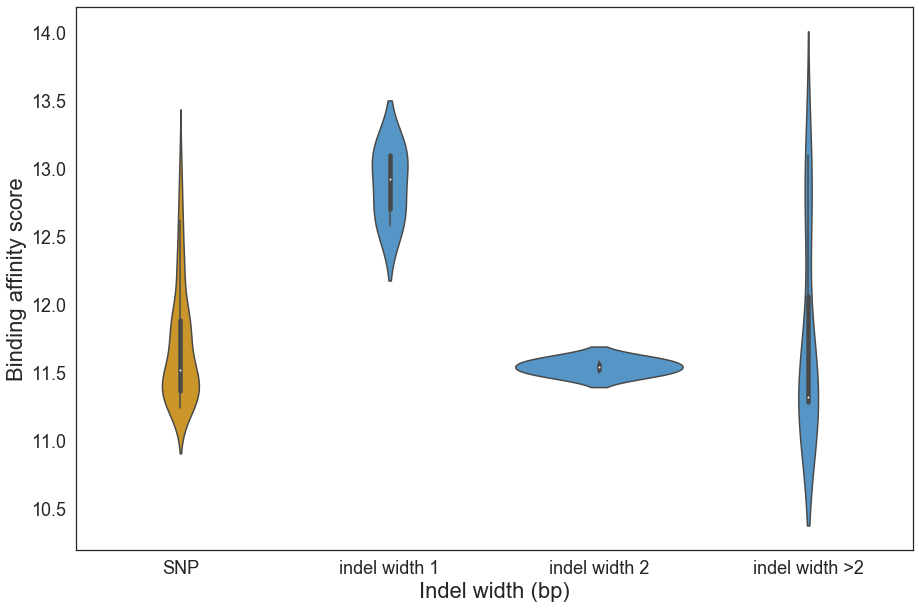

In [43]:
palette = [
    "#E5A00E",
    "#4399D9",
    "#4399D9",
    "#4399D9",
    "#4399D9",
    "#4399D9",
    "#4399D9"
]
plot_violin(gata1_df_hap, palette)

## GRAFIMO performance benchmark

We benchmarked GRAFIMO comparing its running time and memory usage with those of FIMO (Grant *et al*., 2011). To perform the tests, we searched CTCF motif on forward and reverse strand of 1000 genomic regions on human chr22 of increasing length (from 1 to 9 million of bp). 

We first define some functions used during the analysis.

In [44]:
def read_tsv(fname, tool):
    data = {"time":[], "memory":[], "bp":[]}
    ifstream = open(fname, mode="r")
    ifstream.readline()  # header
    while True:
        line = ifstream.readline()
        if not line: break # EOF
        line = line.strip().split()
        data["time"].append(float(line[0]))
        data["memory"].append(float(line[1]))
        data["bp"].append(int(line[2]))
    df = pd.DataFrame(data)
    df["tool"] = [tool] * len(df)
    return df

In [45]:
def mem2Mb(memKb):
     return np.round(memKb/1000, 2)

In [46]:
def compute_mean_std(df):
    df_new = {"time":[], "memory":[], "bp":[], "Tool":[], "std_time":[], "std_memory":[]}
    for i in range(1,10):
        tmp = df[df.bp == i]
        df_new["time"].append(np.mean(tmp.iloc[:,0].tolist()))
        df_new["std_time"].append(np.std(tmp.iloc[:,0].tolist()))
        df_new["memory"].append(np.mean(tmp.iloc[:,1].tolist()))
        df_new["std_memory"].append(np.std(tmp.iloc[:,1].tolist()))
        df_new["bp"].append(tmp.iloc[0,2])
        df_new["Tool"].append(tmp.iloc[0,3])
    df_tmp = pd.DataFrame({"time":[0], "memory":[0], "bp": [0], "Tool":[df.iloc[0,3]], "std_time":[0], "std_memory":[0]})
    return pd.concat([df_tmp, pd.DataFrame(df_new)])

### Comparing GRAFIMO and FIMO time and memory usage

To run FIMO, we created created a FASTA file for each set of genomic coordinates. We assessed GRAFIMO performance by scanning chr22 without any encoded genetic for potential CTCF motif occurrences. Moreover, since FIMO does not provide a parallel implementation, we run GRAFIMO on a single thread. In this test setting FIMO proves to be faster and to use less memory than GRAFIMO.

In [47]:
fimo = read_tsv("./time-mem_benchmark/fimo_time_mem.tsv", "FIMO")
fimo["memory"] = fimo.apply(lambda x : mem2Mb(x[1]), axis=1)  # convert memory from Kb to Mb
fimo

,time,memory,bp,tool
0,0.000,0.00,0,FIMO
1,0.293,7.08,1,FIMO
2,0.700,7.04,2,FIMO
3,1.158,7.22,3,FIMO
4,1.503,7.33,4,FIMO
5,1.864,7.50,5,FIMO
6,2.254,7.61,6,FIMO
7,2.828,7.74,7,FIMO
8,3.159,7.81,8,FIMO
9,3.246,7.86,9,FIMO


In [48]:
grafimo = read_tsv("./time-mem_benchmark/grafimo_time_mem.tsv", "GRAFIMO")
grafimo["memory"] = grafimo.apply(lambda x : mem2Mb(x[1]), axis=1)  # convert memory from Kb to Mb
grafimo

,time,memory,bp,tool
0,0.000,0.00,0,GRAFIMO
1,279.536,1719.45,1,GRAFIMO
2,370.621,3333.35,2,GRAFIMO
3,462.114,5209.60,3,GRAFIMO
4,553.108,6560.96,4,GRAFIMO
5,630.021,7916.12,5,GRAFIMO
6,723.566,10315.56,6,GRAFIMO
7,833.793,11664.54,7,GRAFIMO
8,926.477,13016.98,8,GRAFIMO
9,990.073,14368.54,9,GRAFIMO


/Users/manuel/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


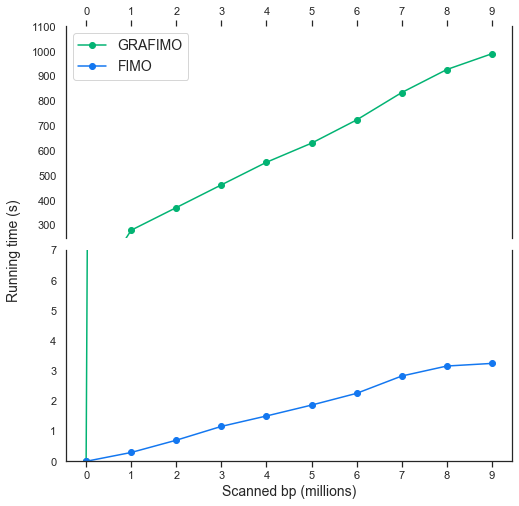

In [49]:
afont = {"fontname":"Arial"}
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8))
ax.plot_date(list(map(str, grafimo.bp)), grafimo.time, color="#02B373", 
             label="GRAFIMO", linestyle="-")
ax.plot_date(list(map(str, fimo.bp)), fimo.time, color="#1377F0", 
             label="FIMO", linestyle="-")
ax2.plot_date(list(map(str, grafimo.bp)), grafimo.time, color="#02B373", 
             label="GRAFIMO", linestyle="-")
ax2.plot_date(list(map(str, fimo.bp)), fimo.time, color="#1377F0", 
             label="FIMO", linestyle="-")
ax.set_ylim(250, 1100)
ax2.set_ylim(0, 7)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off') 
ax2.xaxis.tick_bottom()
ax.set_xticklabels(list(map(str, fimo.bp)), **afont)
ax2.set_xlabel("Scanned bp (millions)", size=14, **afont)
ax2.set_ylabel("Running time (s)", size=14, **afont)
ax2.yaxis.set_label_coords(-0.1, 1)
plt.subplots_adjust(hspace = 0.06)
ax.legend(fontsize=14)
plt.show()

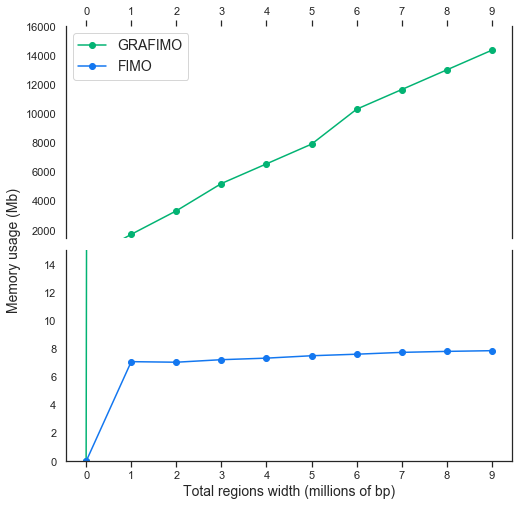

In [50]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8))
ax.plot_date(list(map(str, grafimo.bp)), grafimo.memory, color="#02B373", 
             label="GRAFIMO", linestyle="-")
ax.plot_date(list(map(str, fimo.bp)), fimo.memory, color="#1377F0", 
             label="FIMO", linestyle="-")
ax2.plot_date(list(map(str, grafimo.bp)), grafimo.memory, color="#02B373", 
             label="GRAFIMO", linestyle="-")
ax2.plot_date(list(map(str, fimo.bp)), fimo.memory, color="#1377F0", 
             label="FIMO", linestyle="-")
ax.set_ylim(1500, 16000)
ax2.set_ylim(0, 15)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  
ax2.xaxis.tick_bottom()
ax.set_xticklabels(list(map(str, fimo.bp)), **afont)
ax2.set_xlabel("Total regions width (millions of bp)", size=14, **afont)
ax2.set_ylabel("Memory usage (Mb)", size=14, **afont)
ax2.yaxis.set_label_coords(-0.1, 1)
plt.subplots_adjust(hspace = 0.06)
ax.legend(fontsize=14)
plt.show()

In addition, we benchmarked GRAFIMO running time using a single thread when performing a motif search on chr22 VG with 1000GP variants encoded (2548 individuals). Excluding the preprocessing required to retrieve the FASTA genomic sequences for each subjects from running time calculations, in this setting GRAFIMO proves to be faster, although FIMO performs similarly for regions up to 1 million of bp. Moreover, when scanning chr22 VG for CTCF motif occurrences with 16 threads, GRAFIMO proves to be significantly faster.

In [51]:
fimo_1kgp = read_tsv("./time-mem_benchmark/fimo_time_mem_1kgp.tsv", "FIMO")
fimo_1kgp["memory"] = fimo_1kgp.apply(lambda x : mem2Mb(x[1]), axis=1)
fimo_1kgp

,time,memory,bp,tool
0,0.000,0.00,0,FIMO
1,746.564,7.08,1,FIMO
2,1783.600,7.04,2,FIMO
3,2950.584,7.22,3,FIMO
4,3829.644,7.33,4,FIMO
5,4752.019,7.50,5,FIMO
6,5743.192,7.61,6,FIMO
7,7205.744,7.74,7,FIMO
8,8049.132,7.81,8,FIMO
9,8270.807,7.86,9,FIMO


In [52]:
grafimo_1kgp = read_tsv(
    "./time-mem_benchmark/grafimo_time_mem_1kgp_1thread.tsv", "GRAFIMO 1KGP 1 thread"
)
grafimo_1kgp["memory"] = grafimo_1kgp.apply(lambda x : mem2Mb(x[1]), axis=1)
grafimo_1kgp

,time,memory,bp,tool
0,0.000,0.00,0,GRAFIMO 1KGP 1 thread
1,1246.604,6222.36,1,GRAFIMO 1KGP 1 thread
2,1641.164,12610.04,2,GRAFIMO 1KGP 1 thread
3,1898.843,16407.38,3,GRAFIMO 1KGP 1 thread
4,2269.183,22487.25,4,GRAFIMO 1KGP 1 thread
5,2624.390,28622.52,5,GRAFIMO 1KGP 1 thread
6,2927.317,33198.62,6,GRAFIMO 1KGP 1 thread
7,3083.162,36213.49,7,GRAFIMO 1KGP 1 thread
8,3250.794,37061.35,8,GRAFIMO 1KGP 1 thread
9,3568.130,40774.05,9,GRAFIMO 1KGP 1 thread


In [53]:
grafimo_1kgp_16t = read_tsv(
    "./time-mem_benchmark/grafimo_time_mem_1kgp_16thread.tsv", "GRAFIMO 1KGP 16 threads"
)
grafimo_1kgp_16t["memory"] = grafimo_1kgp_16t.apply(lambda x : mem2Mb(x[1]), axis=1)
grafimo_1kgp_16t

,time,memory,bp,tool
0,0.000,0.00,0,GRAFIMO 1KGP 16 threads
1,212.463,5820.49,1,GRAFIMO 1KGP 16 threads
2,408.070,12489.89,2,GRAFIMO 1KGP 16 threads
3,485.536,17175.80,3,GRAFIMO 1KGP 16 threads
4,576.243,23207.00,4,GRAFIMO 1KGP 16 threads
5,594.303,28852.42,5,GRAFIMO 1KGP 16 threads
6,644.676,33818.63,6,GRAFIMO 1KGP 16 threads
7,700.439,36459.90,7,GRAFIMO 1KGP 16 threads
8,752.810,39423.55,8,GRAFIMO 1KGP 16 threads
9,942.310,43938.10,9,GRAFIMO 1KGP 16 threads


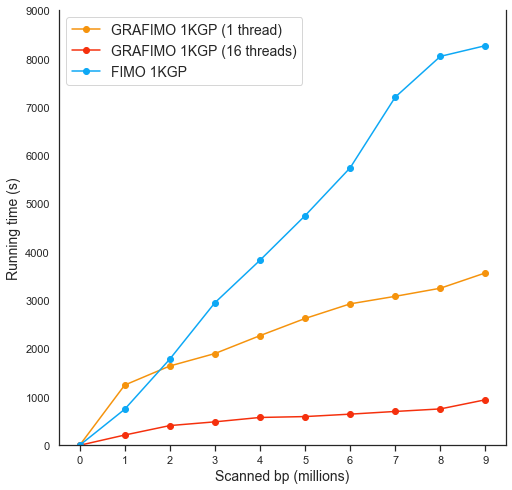

In [54]:
afont = {"fontname":"Arial"}
f, ax = plt.subplots(1, 1, sharex=True, figsize=(8,8))
ax.plot_date(
    list(map(str, grafimo_1kgp.bp)), grafimo_1kgp.time, 
    color="#F5930D", label="GRAFIMO 1KGP (1 thread)", linestyle="-"
)
ax.plot_date(
    list(map(str, grafimo_1kgp_16t.bp)), grafimo_1kgp_16t.time,
    color="#F5300D", label="GRAFIMO 1KGP (16 threads)", linestyle="-"
)
ax.plot_date(
    list(map(str, fimo_1kgp.bp)), fimo_1kgp.time, 
    color="#0DA8F5", label="FIMO 1KGP", linestyle="-"
)
ax.set_ylim(0, 9000)
ax.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  
ax.xaxis.tick_bottom()
ax.set_xticklabels(list(map(str, fimo.bp)), **afont)
ax.set_xlabel("Scanned bp (millions)", size=14, **afont)
ax.set_ylabel("Running time (s)", size=14, **afont)
plt.subplots_adjust(hspace = 0.06)
ax.legend(fontsize=14)
plt.show()

### GRAFIMO running time and memory usage scalability

We assessed the changes in GRAFIMO's running time and memory usage running the tool in parallel on 1, 4, 8 and 16 threads. To benchmarke the performances we searched for potential CTCF motif occurrences on chr22 VG, enriched with 1000GP genetic variants.

Running the tool on multiple cores resulted in a considerable reduction of running time at the cost of an increased memory usage.

In [55]:
grafimo_1kgp_4t = read_tsv(
    "./time-mem_benchmark/grafimo_time_mem_1kgp_4thread.tsv", "GRAFIMO 1KGP 4 thread"
)
grafimo_1kgp_4t["memory"] = grafimo_1kgp_4t.apply(lambda x : mem2Mb(x[1]), axis=1)
grafimo_1kgp_4t

,time,memory,bp,tool
0,0.00,0.00,0,GRAFIMO 1KGP 4 thread
1,386.32,5813.76,1,GRAFIMO 1KGP 4 thread
2,641.26,12640.04,2,GRAFIMO 1KGP 4 thread
3,737.98,17407.38,3,GRAFIMO 1KGP 4 thread
4,857.23,23507.25,4,GRAFIMO 1KGP 4 thread
5,940.85,29652.54,5,GRAFIMO 1KGP 4 thread
6,1086.94,34238.62,6,GRAFIMO 1KGP 4 thread
7,1120.76,37011.09,7,GRAFIMO 1KGP 4 thread
8,1292.33,38075.65,8,GRAFIMO 1KGP 4 thread
9,1507.99,41920.99,9,GRAFIMO 1KGP 4 thread


In [56]:
grafimo_1kgp_8t = read_tsv(
    "./time-mem_benchmark/grafimo_time_mem_1kgp_8thread.tsv", "GRAFIMO 1KGP 8 threads"
)
grafimo_1kgp_8t["memory"] = grafimo_1kgp_8t.apply(lambda x : mem2Mb(x[1]), axis=1)
grafimo_1kgp_8t

,time,memory,bp,tool
0,0.000,0.00,0,GRAFIMO 1KGP 8 threads
1,254.880,4942.37,1,GRAFIMO 1KGP 8 threads
2,464.930,12485.91,2,GRAFIMO 1KGP 8 threads
3,546.376,17278.07,3,GRAFIMO 1KGP 8 threads
4,650.503,23315.57,4,GRAFIMO 1KGP 8 threads
5,734.323,29541.46,5,GRAFIMO 1KGP 8 threads
6,776.546,33919.35,6,GRAFIMO 1KGP 8 threads
7,826.740,36763.67,7,GRAFIMO 1KGP 8 threads
8,901.450,38476.52,8,GRAFIMO 1KGP 8 threads
9,1203.100,42895.13,9,GRAFIMO 1KGP 8 threads


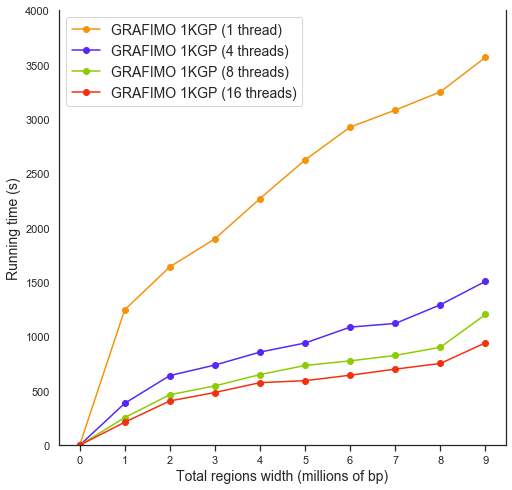

In [57]:
afont = {"fontname":"Arial"}
f, ax = plt.subplots(1, 1, sharex=True, figsize=(8,8))
ax.plot_date(
    list(map(str, grafimo_1kgp.bp)), grafimo_1kgp.time, 
    color="#F5930D", label="GRAFIMO 1KGP (1 thread)", linestyle="-"
)
ax.plot_date(
    list(map(str, grafimo_1kgp_4t.bp)), grafimo_1kgp_4t.time,
    color = "#5627F7", label="GRAFIMO 1KGP (4 threads)", linestyle="-"
)
ax.plot_date(
    list(map(str, grafimo_1kgp_8t.bp)), grafimo_1kgp_8t.time, 
    color="#8ECB03", label="GRAFIMO 1KGP (8 threads)", linestyle="-"
)
ax.plot_date(
    list(map(str, grafimo_1kgp_16t.bp)), grafimo_1kgp_16t.time,
    color="#F5300D", label="GRAFIMO 1KGP (16 threads)", linestyle="-"
)
ax.set_ylim(0, 4000)
ax.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  
ax.xaxis.tick_bottom()
ax.set_xticklabels(list(map(str, grafimo_1kgp.bp)), **afont)
ax.set_xlabel("Total regions width (millions of bp)", size=14, **afont)
ax.set_ylabel("Running time (s)", size=14, **afont)
plt.subplots_adjust(hspace = 0.06)
ax.legend(fontsize=14)
plt.show()

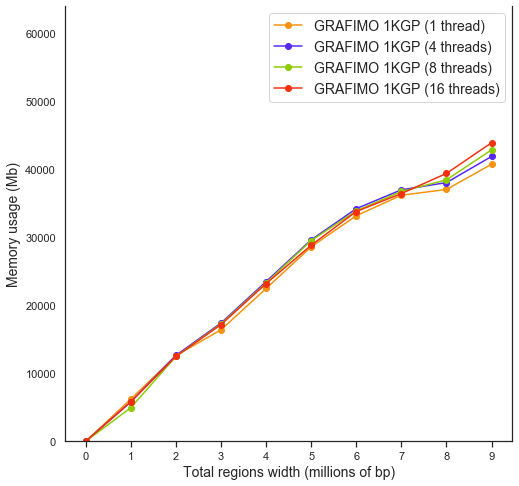

In [58]:
afont = {"fontname":"Arial"}
f, ax = plt.subplots(1, 1, sharex=True, figsize=(8,8))
ax.plot_date(
    list(map(str, grafimo_1kgp.bp)), grafimo_1kgp.memory, 
    color="#F5930D", label="GRAFIMO 1KGP (1 thread)", linestyle="-"
)
ax.plot_date(
    list(map(str, grafimo_1kgp_4t.bp)), grafimo_1kgp_4t.memory,
    color = "#5627F7", label="GRAFIMO 1KGP (4 threads)", linestyle="-"
)
ax.plot_date(
    list(map(str, grafimo_1kgp_8t.bp)), grafimo_1kgp_8t.memory, 
    color="#8ECB03", label="GRAFIMO 1KGP (8 threads)", linestyle="-"
)
ax.plot_date(
    list(map(str, grafimo_1kgp_16t.bp)), grafimo_1kgp_16t.memory,
    color="#F5300D", label="GRAFIMO 1KGP (16 threads)", linestyle="-"
)
ax.set_ylim(0, 64000)
ax.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  
ax.xaxis.tick_bottom()
ax.set_xticklabels(list(map(str, grafimo_1kgp_16t.bp)), **afont)
ax.set_xlabel("Total regions width (millions of bp)", size=14, **afont)
ax.set_ylabel("Memory usage (Mb)", size=14, **afont)
plt.subplots_adjust(hspace = 0.06)
ax.legend(fontsize=14)
plt.show()